In [40]:
# Load libraries
import pandas as pd
from matplotlib import pyplot
import sklearn
from sklearn.feature_selection import SelectKBest 
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

In [3]:
# Load data
# Load CSV files with Pandas
from pandas import read_csv
dataset = read_csv('../datasets/german_credit_data.csv')
# Viewing the data 
pd.set_option('display.width', 100)
dataset.head(3)

,Age,Sex,Job,Housing,SavingAccounts,CheckingAccount,CreditAmount,Duration,Purpose,Risk
0,67,male,2,own,NaN,little,1169,6,radio/TV,good
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
2,49,male,1,own,little,NaN,2096,12,education,good


In [4]:
# Reviewing the dimensions of the dataset
dataset.shape

(1000, 10)

In [5]:
type(dataset)

pandas.core.frame.DataFrame

<a id='2'></a>
# 3. Exploratory Data Analysis

<a id='2.1'></a>
## 3.1. Descriptive Statistics

In [6]:
# Reviewing the data types of the attributes in the data
# types
pd.set_option('display.max_rows', 500)
dataset.dtypes

Age                 int64
Sex                object
Job                 int64
Housing            object
SavingAccounts     object
CheckingAccount    object
CreditAmount        int64
Duration            int64
Purpose            object
Risk               object
dtype: object

In [7]:
# Summarizing the data using descriptive statistics
# describe data
pd.set_option('display.precision', 3)
dataset.describe()

,Age,Job,CreditAmount,Duration
count,1000.000,1000.000,1000.000,1000.000
mean,35.546,1.904,3271.258,20.903
std,11.375,0.654,2822.737,12.059
min,19.000,0.000,250.000,4.000
25%,27.000,2.000,1365.500,12.000
50%,33.000,2.000,2319.500,18.000
75%,42.000,2.000,3972.250,24.000
max,75.000,3.000,18424.000,72.000


In [8]:
# class distribution
dataset.groupby('Housing').size()

Housing
free    108
own     713
rent    179
dtype: int64

<a id='2.2'></a>
## 3.2. Data Visualization

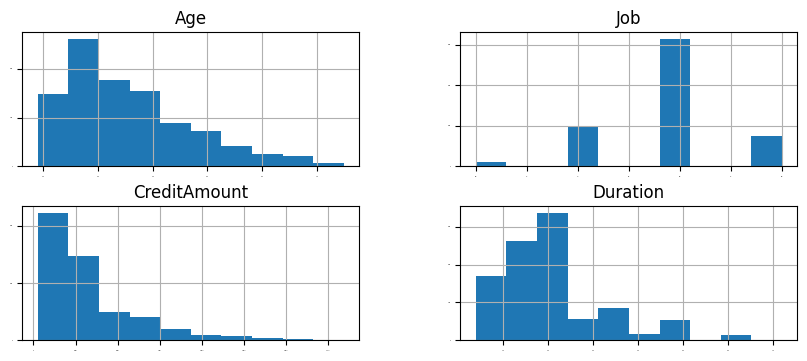

In [14]:
# Univariate plot: histogram
dataset.hist(sharex=False, sharey=False, xlabelsize=1, ylabelsize=1, figsize=(10,4))
pyplot.show()

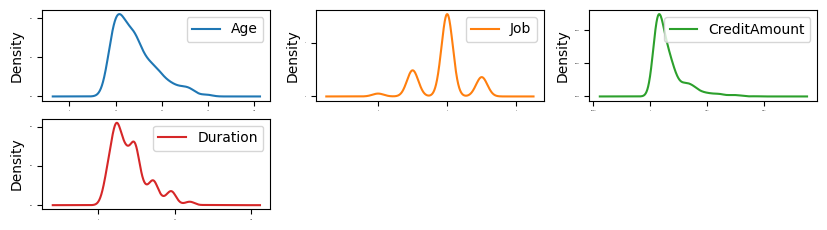

In [16]:
# Univariate plot: density plot
dataset.plot(kind='density', subplots=True, layout=(3,3), sharex=False, legend=True, fontsize=1, figsize=(10,4))
pyplot.show()

<a id='4'></a>
## 4. Data preparation

<a id='4.1'></a>
## 4.1. Data Cleaning
Check for the NAs in the rows, either drop them or fill them with the mean of the column

In [9]:
#Checking for any null values and removing the null values'''
print('Null Values =',dataset.isnull().values.any())

Null Values = True


Given that there are null values drop the rown contianing the null values.

In [10]:
# Drop the rows containing NA
dataset = dataset.dropna(axis=0)
# Fill na with 0
#dataset.fillna('0')

#Filling the NAs with the mean of the column.
#dataset['col'] = dataset['col'].fillna(dataset['col'].mean())
dataset.head(3)

,Age,Sex,Job,Housing,SavingAccounts,CheckingAccount,CreditAmount,Duration,Purpose,Risk
1,22,female,2,own,little,moderate,5951,48,radio/TV,bad
3,45,male,2,free,little,little,7882,42,furniture/equipment,good
4,53,male,2,free,little,little,4870,24,car,bad


<a id='3.2'></a>
## 4.2. Handling Categorical Data

In [11]:
from sklearn.preprocessing import LabelEncoder

lb_make = LabelEncoder()
dataset["Sex_Code"] = lb_make.fit_transform(dataset["Sex"])
dataset["Housing_Code"] = lb_make.fit_transform(dataset["Housing"])
dataset["SavingAccount_Code"] = lb_make.fit_transform(dataset["SavingAccounts"].fillna('0'))
dataset["CheckingAccount_Code"] = lb_make.fit_transform(dataset["CheckingAccount"].fillna('0'))
dataset["Purpose_Code"] = lb_make.fit_transform(dataset["Purpose"])
dataset["Risk_Code"] = lb_make.fit_transform(dataset["Risk"])
dataset[["Sex", "Sex_Code","Housing","Housing_Code","Risk_Code","Risk"]].head(10)

,Sex,Sex_Code,Housing,Housing_Code,Risk_Code,Risk
1,female,0,own,1,0,bad
3,male,1,free,0,1,good
4,male,1,free,0,0,bad
7,male,1,rent,2,1,good
9,male,1,own,1,0,bad
10,female,0,rent,2,0,bad
11,female,0,rent,2,0,bad
12,female,0,own,1,1,good
13,male,1,own,1,0,bad
14,female,0,rent,2,1,good


In [12]:
#dropping the old features
dataset.drop(['Sex','Housing','SavingAccounts','CheckingAccount','Purpose','Risk'],axis=1,inplace=True)
dataset.head(5)

,Age,Job,CreditAmount,Duration,Sex_Code,Housing_Code,SavingAccount_Code,CheckingAccount_Code,Purpose_Code,Risk_Code
1,22,2,5951,48,0,1,0,1,5,0
3,45,2,7882,42,1,0,0,0,4,1
4,53,2,4870,24,1,0,0,0,1,0
7,35,3,6948,36,1,2,0,1,1,1
9,28,3,5234,30,1,1,0,1,1,0


<a id='4.3'></a>
## 4.3. Feature selection
Statistical tests can be used to select those features that have the strongest relationship with the output variable.The scikit-learn library provides the SelectKBest class that can be used with a suite of different statistical tests to select a specific number of features.
The example below uses the chi-squared (chi²) statistical test for non-negative features to select 10 of the best features from the Dataset.

In [13]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

bestfeatures = SelectKBest(score_func=chi2, k=5)
bestfeatures

SelectKBest(k=5, score_func=<function chi2 at 0x130c36660>)

In [14]:
Y= dataset["Risk_Code"]
X = dataset.loc[:, dataset.columns != 'Risk_Code']
fit = bestfeatures.fit(X,Y)
dfscores = pd.DataFrame(fit.scores_)
dfcolumns = pd.DataFrame(X.columns)
#concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)
featureScores.columns = ['Specs','Score']  #naming the dataframe columns
print(featureScores.nlargest(10,'Score'))  #print 10 best features

                  Specs      Score
2          CreditAmount  45853.601
3              Duration    327.508
6    SavingAccount_Code     14.395
7  CheckingAccount_Code      7.096
0                   Age      6.534
8          Purpose_Code      1.902
4              Sex_Code      0.671
1                   Job      0.318
5          Housing_Code      0.007


As it can be seem from the numbers above Credit Amount is the most important feature followed by duration.

<a id='3.4'></a>
## 4.4. Data Transformation

<a id='3.4.1'></a>
### 4.4.1. Rescale Data
When your data is comprised of attributes with varying scales, many machine learning algorithms
can benefit from rescaling the attributes to all have the same scale. Often this is referred to
as normalization and attributes are often rescaled into the range between 0 and 1.

In [15]:
from sklearn.preprocessing import MinMaxScaler
X = dataset.loc[:, dataset.columns != 'Risk_Code']
scaler = MinMaxScaler(feature_range=(0, 1))
rescaledX = pd.DataFrame(scaler.fit_transform(X))
# summarize transformed data
rescaledX.head(5)

,0,1,2,3,4,5,6,7,8
0,0.054,0.667,0.313,0.636,0.0,0.5,0.0,0.5,0.714
1,0.464,0.667,0.419,0.545,1.0,0.0,0.0,0.0,0.571
2,0.607,0.667,0.253,0.273,1.0,0.0,0.0,0.0,0.143
3,0.286,1.000,0.368,0.455,1.0,1.0,0.0,0.5,0.143
4,0.161,1.000,0.273,0.364,1.0,0.5,0.0,0.5,0.143


<a id='4.4.2'></a>
### 4.4.2. Standardize Data
Standardization is a useful technique to transform attributes with a Gaussian distribution and
differing means and standard deviations to a standard Gaussian distribution with a mean of
0 and a standard deviation of 1.

In [16]:
from sklearn.preprocessing import StandardScaler
X = dataset.loc[:, dataset.columns != 'Risk_Code']
scaler = StandardScaler().fit(X)
StandardisedX = pd.DataFrame(scaler.fit_transform(X))
# summarize transformed data
StandardisedX.head(5)

,0,1,2,3,4,5,6,7,8
0,-1.094,0.183,0.913,2.139,-1.452,-0.145,-0.451,0.557,1.063
1,0.859,0.183,1.573,1.658,0.689,-1.900,-0.451,-0.958,0.561
2,1.538,0.183,0.544,0.214,0.689,-1.900,-0.451,-0.958,-0.944
3,0.009,1.648,1.254,1.176,0.689,1.611,-0.451,0.557,-0.944
4,-0.585,1.648,0.668,0.695,0.689,-0.145,-0.451,0.557,-0.944


<a id='4.4.3'></a>
### 4.4.3. Normalize Data
Normalizing in scikit-learn refers to rescaling each observation (row) to have a length of 1 (called
a unit norm or a vector with the length of 1 in linear algebra).

In [17]:
from sklearn.preprocessing import Normalizer
X = dataset.loc[:, dataset.columns != 'Risk_Code']
scaler = Normalizer().fit(X)
NormalizedX = pd.DataFrame(scaler.fit_transform(X))
# summarize transformed data
NormalizedX.head(5)

,0,1,2,3,4,5,6,7,8
0,0.004,3.361e-04,1.0,0.008,0.000e+00,1.680e-04,0.0,1.680e-04,8.402e-04
1,0.006,2.537e-04,1.0,0.005,1.269e-04,0.000e+00,0.0,0.000e+00,5.075e-04
2,0.011,4.106e-04,1.0,0.005,2.053e-04,0.000e+00,0.0,0.000e+00,2.053e-04
3,0.005,4.318e-04,1.0,0.005,1.439e-04,2.878e-04,0.0,1.439e-04,1.439e-04
4,0.005,5.732e-04,1.0,0.006,1.911e-04,1.911e-04,0.0,1.911e-04,1.911e-04


<a id='5'></a>
# 5. Evaluate Algorithms and Models

<a id='5.1'></a>
## 5.1. Train Test Split

In [20]:
# split out validation dataset for the end
Y= dataset["Risk_Code"]
X = dataset.loc[:, dataset.columns != 'Risk_Code']
scaler = StandardScaler().fit(X)
StandardisedX = pd.DataFrame(scaler.fit_transform(X))
validation_size = 0.2
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [49]:
X_train.head(3)

,Age,Job,CreditAmount,Duration,Sex_Code,Housing_Code,SavingAccount_Code,CheckingAccount_Code,Purpose_Code
746,23,2,2511,15,0,2,0,0,1
31,27,2,4020,24,1,1,0,0,4
315,31,2,2746,36,1,1,0,0,4


<a id='5.2'></a>
## 5.2. Test Options and Evaluation Metrics

In [29]:
# test options for classification
num_folds = 10
seed = 7
scoring = 'accuracy'
#scoring ='neg_log_loss'
#scoring = 'roc_auc'

<a id='5.3'></a>
## 5.3. Compare Models and Algorithms

<a id='5.3.1'></a>
### 5.3.1. Common Models

In [25]:
# spot check the algorithms
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
#Neural Network
models.append(('NN', MLPClassifier()))

<a id='5.3.2'></a>
### 5.3.2. Ensemble Models

In [41]:
#Ensable Models 
# Boosting methods
models.append(('AB', AdaBoostClassifier()))
models.append(('GBM', GradientBoostingClassifier()))
# Bagging methods
models.append(('RF', RandomForestClassifier()))
models.append(('ET', ExtraTreesClassifier()))

### K-folds cross validation

In [34]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, shuffle=True, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

/Users/bangbui/anaconda3/envs/python311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Users/bangbui/anaconda3/envs/python311/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:460: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/mod

LR: 0.609001 (0.054585)
LDA: 0.606562 (0.067055)
KNN: 0.546748 (0.057895)
CART: 0.570848 (0.090067)
NB: 0.613879 (0.067705)
SVM: 0.601800 (0.059216)
NN: 0.493902 (0.066584)


<a id='6'></a>
# 6. Model Tuning and Grid Search

In [37]:
# Grid Search: SVM algorithm tuning
'''
C : float, optional (default=1.0)
Penalty parameter C of the error term.

kernel : string, optional (default=’rbf’)
Specifies the kernel type to be used in the algorithm. 
It must be one of ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’ or a callable. 
Parameters of SVM are C and kernel. 
Try a number of kernels with various values of C with less bias and more bias (less than and greater than 1.0 respectively
''' 
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
c_values = [0.1, 0.3, 0.5, 0.7, 0.9, 1.0, 1.3, 1.5]
kernel_values = ['linear', 'poly', 'rbf']
param_grid = dict(C=c_values, kernel=kernel_values)
model = SVC()
kfold = KFold(n_splits=num_folds, shuffle=True,random_state=seed)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(rescaledX, Y_train)

#Print Results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
ranks = grid_result.cv_results_['rank_test_score']
for mean, stdev, param, rank in zip(means, stds, params, ranks):
    print("#%d %f (%f) with: %r" % (rank, mean, stdev, param))

Best: 0.649535 using {'C': 0.7, 'kernel': 'rbf'}
#8 0.616376 (0.071503) with: {'C': 0.1, 'kernel': 'linear'}
#23 0.592218 (0.053105) with: {'C': 0.1, 'kernel': 'poly'}
#24 0.570790 (0.051268) with: {'C': 0.1, 'kernel': 'rbf'}
#18 0.601974 (0.065673) with: {'C': 0.3, 'kernel': 'linear'}
#19 0.601800 (0.066896) with: {'C': 0.3, 'kernel': 'poly'}
#7 0.625552 (0.089579) with: {'C': 0.3, 'kernel': 'rbf'}
#11 0.604413 (0.069859) with: {'C': 0.5, 'kernel': 'linear'}
#22 0.601510 (0.087348) with: {'C': 0.5, 'kernel': 'poly'}
#6 0.637631 (0.084031) with: {'C': 0.5, 'kernel': 'rbf'}
#11 0.604413 (0.069859) with: {'C': 0.7, 'kernel': 'linear'}
#10 0.606330 (0.089217) with: {'C': 0.7, 'kernel': 'poly'}
#1 0.649535 (0.090117) with: {'C': 0.7, 'kernel': 'rbf'}
#11 0.604413 (0.069859) with: {'C': 0.9, 'kernel': 'linear'}
#9 0.613531 (0.085245) with: {'C': 0.9, 'kernel': 'poly'}
#5 0.640070 (0.088256) with: {'C': 0.9, 'kernel': 'rbf'}
#11 0.604413 (0.069859) with: {'C': 1.0, 'kernel': 'linear'}
#21 0.

<a id='7'></a>
# 7. Finalise the Model

Looking at the details above GBM might be worthy of further study, but for now SVM shows a lot of promise as a low complexity and stable model for this problem.

Finalize Model with best parameters found during tuning step.

<a id='7.1'></a>
## 7.1. Results on the Test Dataset

In [42]:
# prepare model
scaler = StandardScaler().fit(X_train)
rescaledX = scaler.transform(X_train)
model = GradientBoostingClassifier(n_estimators=20, max_depth=5) # rbf is default kernel
model.fit(X_train, Y_train)

GradientBoostingClassifier(max_depth=5, n_estimators=20)

In [43]:
# estimate accuracy on validation set
rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(X_validation)
print(accuracy_score(Y_validation, predictions))
print(confusion_matrix(Y_validation, predictions))
print(classification_report(Y_validation, predictions))

0.6761904761904762
[[31 21]
 [13 40]]
              precision    recall  f1-score   support

           0       0.70      0.60      0.65        52
           1       0.66      0.75      0.70        53

    accuracy                           0.68       105
   macro avg       0.68      0.68      0.67       105
weighted avg       0.68      0.68      0.67       105



In [44]:
predictions

array([0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1])

In [45]:
Y_validation

998    0
989    1
664    1
474    0
601    0
918    0
114    1
7      1
593    0
201    1
946    0
156    1
375    0
513    1
177    1
89     0
466    0
537    1
634    0
927    0
454    0
648    0
938    0
530    1
818    1
498    1
197    0
961    1
405    0
432    1
806    1
35     0
531    0
334    0
652    0
22     1
677    0
605    1
515    1
51     1
145    1
729    1
475    0
313    0
252    0
97     1
969    1
88     1
501    1
38     1
273    0
793    1
576    1
479    1
442    1
320    0
212    0
172    0
917    0
812    0
207    1
72     1
727    0
491    0
849    0
919    0
328    1
834    0
835    0
721    0
711    0
347    1
896    1
831    0
521    0
930    1
832    0
623    1
684    1
666    1
458    1
157    1
602    0
284    1
714    0
107    1
422    1
653    0
730    1
416    0
293    1
923    1
876    1
191    0
892    1
709    1
814    0
471    0
398    0
506    1
597    0
44     0
34     1
840    0
47     1
Name: Risk_Code, dtype: int64

<a id='7.2'></a>
## 7.2. Variable Intuition/Feature Importance
Looking at the details above GBM might be worthy of further study, but for now SVM shows a lot of promise as a low complexity and stable model for this problem.
Let us look into the Feature Importance of the GBM model

[0.14516833 0.02830659 0.45901776 0.23322467 0.00482378 0.02255081
 0.03420548 0.02709441 0.04560816]


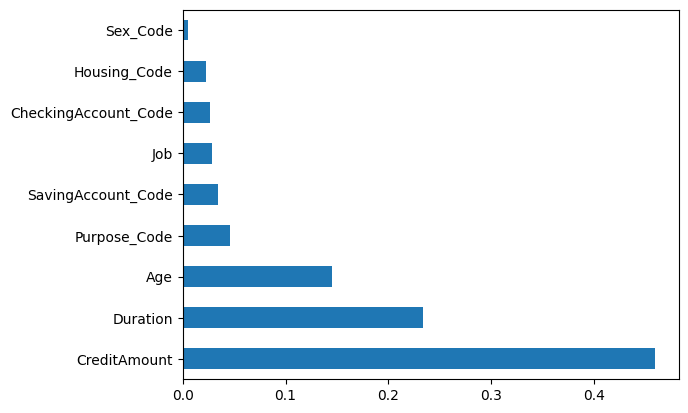

In [46]:
import pandas as pd
import numpy as np
model = GradientBoostingClassifier()
model.fit(rescaledX,Y_train)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
pyplot.show()

<a id='7.3'></a>
## 7.3. Save Model for Later Use

In [47]:
# Save Model Using Pickle
from pickle import dump
from pickle import load

# save the model to disk
filename = 'finalized_model.sav'
dump(model, open(filename, 'wb'))

In [48]:
# some time later...
# load the model from disk
loaded_model = load(open(filename, 'rb'))
# estimate accuracy on validation set
rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(rescaledValidationX)
result = accuracy_score(Y_validation, predictions)
print(result)

0.7047619047619048
